In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from scipy.integrate import odeint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
csvs = sorted(os.listdir('./csv_data/'), reverse=True)

In [3]:
data = pd.DataFrame(columns = ['CCAA', 'fecha', 'casos', 'IA', 'UCI', 'muertes'])
for csv in csvs:
    data_int = pd.read_csv('./csv_data/{}'.format(csv))
    data = data.append(data_int, ignore_index=True).reset_index(drop=True)

Corregir error primera muerte C. Valenciana

In [4]:
data.loc[data.loc[data.CCAA == '1'].index -1, 'muertes'] = 1
data = data.drop(data.loc[data.CCAA == '1'].index).reset_index(drop=True)

Único nombre para Castilla y La Mancha

In [5]:
data.loc[data.CCAA == 'Castilla-LaMancha', 'CCAA'] = 'CastillaLaMancha'

Damos formato a las columnas

In [6]:
data['fecha'] = pd.to_datetime(data['fecha'],format='%d.%m.%Y')
data['casos'] = pd.to_numeric(data.casos)
data['UCI'] = pd.to_numeric(data.UCI)
data['muertes'] = pd.to_numeric(data.muertes)

In [7]:
data = data.sort_values(by=['CCAA','fecha']).reset_index(drop = True)

## Casos en fin de semana

In [75]:
andalucia = data.loc[data.CCAA == 'Andalucía'].copy()

In [76]:
andalucia

,CCAA,fecha,casos,IA,UCI,muertes
0,Andalucía,2020-03-02,12,NaN,NaN,NaN
1,Andalucía,2020-03-03,13,0.15,NaN,NaN
2,Andalucía,2020-03-04,13,0.15,1.0,NaN
3,Andalucía,2020-03-05,12,0.14,1.0,0.0
4,Andalucía,2020-03-06,21,0.25,1.0,0.0
5,Andalucía,2020-03-09,54,0.64,1.0,0.0
6,Andalucía,2020-03-10,71,0.84,1.0,0.0
7,Andalucía,2020-03-11,90,1.07,3.0,0.0
8,Andalucía,2020-03-12,115,1.35,4.0,0.0


In [77]:
def date_lag(vect):
    days = np.array([el.day for el in vect])
    dif = days[1:] - days[:-1]
    return np.where(dif>1)[0]

In [78]:
date_lag(andalucia.fecha)

array([4])

In [79]:
def get_splits(df,ind):    
    return df.loc[:ind],df.loc[ind+1:]

In [80]:
split1, split2 = get_splits(andalucia, date_lag(andalucia.fecha)[0])

In [81]:
def get_new_lines(df, ind):
    lines = pd.DataFrame({'CCAA': df.loc[ind-1:ind,'CCAA'].values,
                          'fecha': [df.loc[ind,'fecha']  + pd.DateOffset(1), df.loc[ind,'fecha']  + pd.DateOffset(2)],
                          'casos' : [np.nan, np.nan], 'IA' : [np.nan, np.nan], 
                          'UCI' : [np.nan, np.nan], 'muertes' : [np.nan, np.nan]})
    return lines

In [82]:
lines = get_new_lines(andalucia, date_lag(andalucia.fecha)[0])

In [83]:
andalucia = pd.concat([split1, lines, split2]).reset_index(drop=True)

In [84]:
andalucia

,CCAA,fecha,casos,IA,UCI,muertes
0,Andalucía,2020-03-02,12.0,NaN,NaN,NaN
1,Andalucía,2020-03-03,13.0,0.15,NaN,NaN
2,Andalucía,2020-03-04,13.0,0.15,1.0,NaN
3,Andalucía,2020-03-05,12.0,0.14,1.0,0.0
4,Andalucía,2020-03-06,21.0,0.25,1.0,0.0
5,Andalucía,2020-03-07,NaN,NaN,NaN,NaN
6,Andalucía,2020-03-08,NaN,NaN,NaN,NaN
7,Andalucía,2020-03-09,54.0,0.64,1.0,0.0
8,Andalucía,2020-03-10,71.0,0.84,1.0,0.0
9,Andalucía,2020-03-11,90.0,1.07,3.0,0.0


In [85]:
def get_line_eq(points):
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords, rcond=-1)[0]
    return m, c

In [86]:
get_line_eq([(6,0.25),(9,0.64)])

(0.13000000000000006, -0.5300000000000009)

In [87]:
def fill_gaps(df, var, ind, rnd):
    point0 = (df.loc[ind,'fecha'].day,df.loc[ind,var])
    point1 = (df.loc[ind+3,'fecha'].day,df.loc[ind+3,var])
    m, c = get_line_eq([point0,point1])
    val0 = np.round(m*df.loc[ind+1,'fecha'].day+c,rnd)
    val1 = np.round(m*df.loc[ind+2,'fecha'].day+c,rnd)
    return val0, val1

In [88]:
andalucia.loc[4+1, 'casos'], andalucia.loc[4+2, 'casos'] = fill_gaps(andalucia, 'casos', 4, 0)

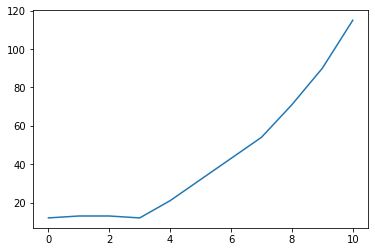

In [89]:
andalucia.casos.plot();

In [91]:
def CCAA_correction(df):
    df = df.reset_index(drop=True)
    ind = date_lag(df['fecha'])
    while len(ind)>0:
        split1, split2 = get_splits(df, ind[0])
        lines = get_new_lines(df, ind[0])
        df = pd.concat([split1, lines, split2]).reset_index(drop=True)
        variables = list(df.columns)
        c = variables.index('fecha')+1
        rounds = [0,2,0,0]
        for var, r in zip(variables[c:],rounds):
            df.loc[ind[0]+1, var], df.loc[ind[0]+2, var] = fill_gaps(df, var, ind[0], r)
        ind = date_lag(df['fecha'])
    return df

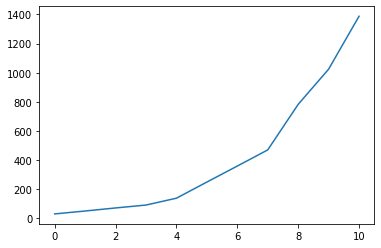

In [96]:
CCAA_correction(data[data.CCAA == 'Madrid']).casos.plot();

In [62]:
data.CCAA.unique()

array(['Andalucía', 'Aragón', 'Asturias', 'Baleares', 'C.Valenciana',
       'Canarias', 'Cantabria', 'CastillaLaMancha', 'CastillayLeón',
       'Cataluña', 'Ceuta', 'Extremadura', 'Galicia', 'LaRioja', 'Madrid',
       'Melilla', 'Murcia', 'Navarra', 'PaísVasco'], dtype=object)

# Nuevos casos / CCAA

In [8]:
data['nuevos_casos'] = np.nan
for CCAA in data.CCAA.unique():
    casos_hoy  = data.loc[data.CCAA == CCAA,'casos'].values[1:]
    casos_ayer = data.loc[data.CCAA == CCAA,'casos'].values[:-1]
    data.loc[data.CCAA == CCAA,'nuevos_casos'] = [np.nan]+list(casos_hoy-casos_ayer)

In [9]:
data['FC'] = np.nan
for CCAA in data.CCAA.unique():
    casos_hoy  = data.loc[data.CCAA == CCAA,'nuevos_casos'].values[2:]
    casos_ayer = data.loc[data.CCAA == CCAA,'nuevos_casos'].values[1:-1]
    data.loc[data.CCAA == CCAA,'FC'] = [np.nan,np.nan]+list(casos_hoy/casos_ayer)

/Users/victor/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/victor/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [10]:
NC_spain = data.groupby(['fecha']).sum()['nuevos_casos'].values

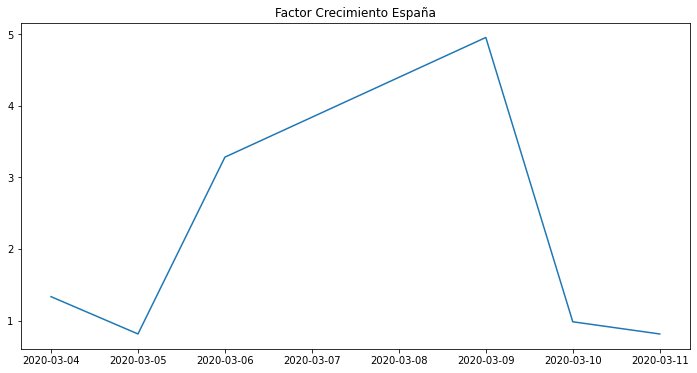

In [11]:
plt.figure(figsize=(12,6))
plt.title('Factor Crecimiento España')
plt.plot(data.groupby(['fecha']).sum().index[2:],NC_spain[2:] / NC_spain[1:-1]);

# Gráficos

## Casos / CCAA

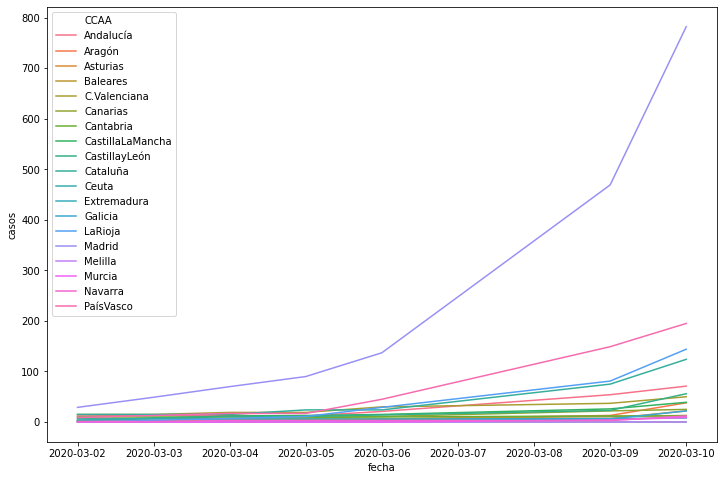

In [62]:
plt.figure(figsize=(12,8))
sns.lineplot(x="fecha", y="casos", hue='CCAA', data=data);

# Nuevos casos / CCAA

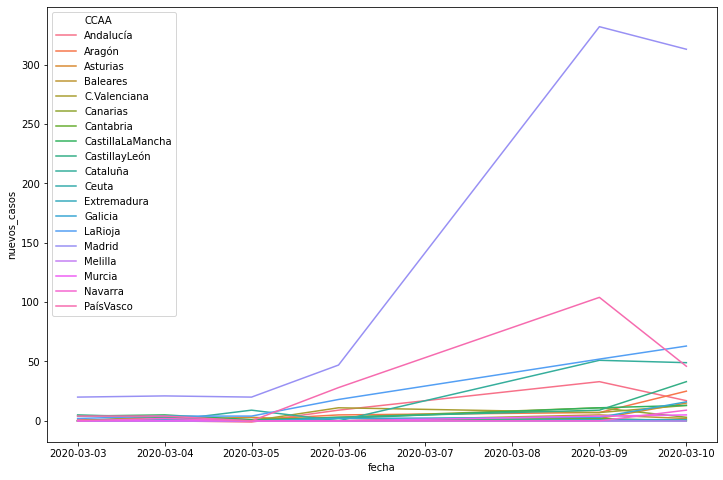

In [63]:
plt.figure(figsize=(12,8))
sns.lineplot(x="fecha", y="nuevos_casos", hue='CCAA', data=data);

# Factor de crecimiento

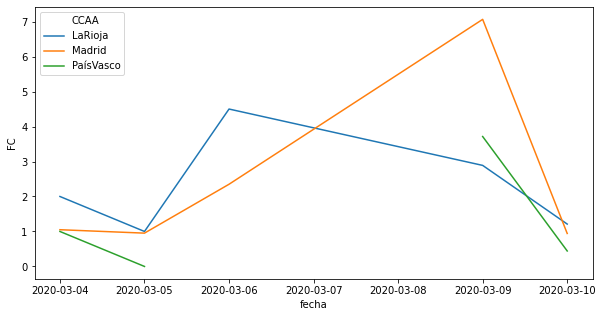

In [64]:
plt.figure(figsize=(10,5))
sns.lineplot(x="fecha", y="FC", hue='CCAA', data=data[data.CCAA.isin(['Madrid','LaRioja','PaísVasco'])]);

## Incidencia acumulada / CCAA

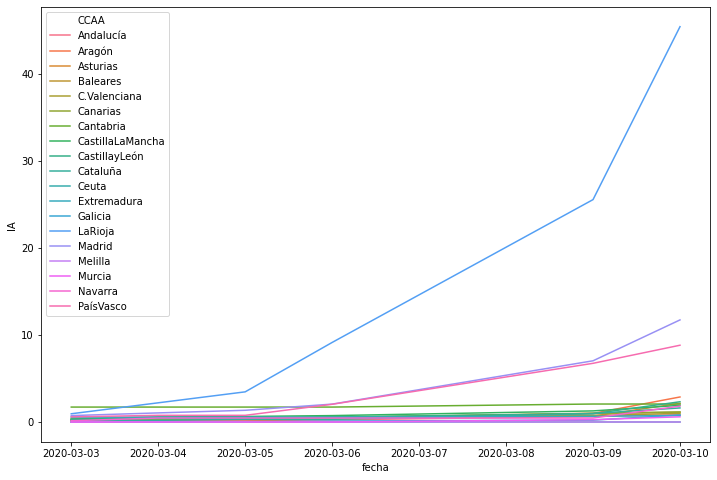

In [11]:
plt.figure(figsize=(12,8))
sns.lineplot(x="fecha", y="IA", hue='CCAA', data=data);

## UCI / CCAA

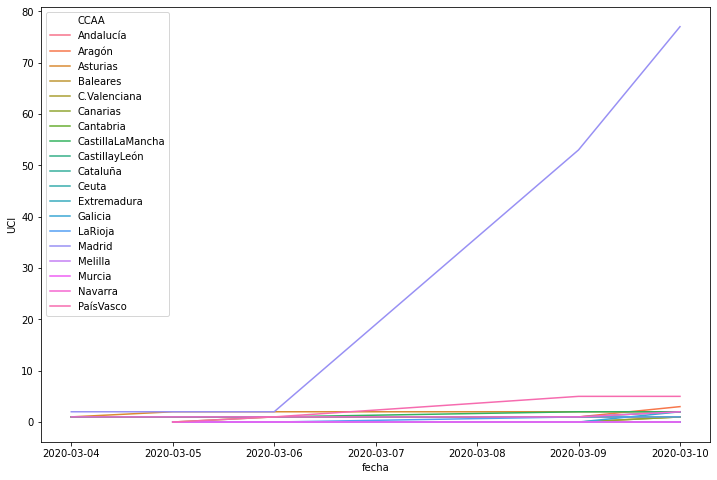

In [12]:
plt.figure(figsize=(12,8))
sns.lineplot(x="fecha", y="UCI", hue='CCAA', data=data);

## Muertes / CCAA

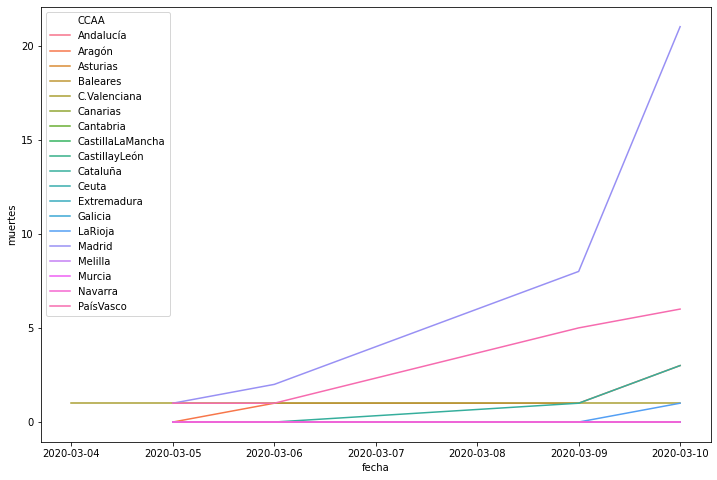

In [13]:
plt.figure(figsize=(12,8))
sns.lineplot(x="fecha", y="muertes", hue='CCAA', data=data);

# SIR MODEL MADRID

*Modelo en desarrollo > No tener en cuenta los valores*

In [14]:
data[data.CCAA == 'Madrid'].sort_values('fecha')

,CCAA,fecha,casos,IA,UCI,muertes,nuevos_casos
98,Madrid,2020-03-02,29,NaN,NaN,NaN,NaN
99,Madrid,2020-03-03,49,0.74,NaN,NaN,20.0
100,Madrid,2020-03-04,70,1.05,2.0,NaN,21.0
101,Madrid,2020-03-05,90,1.35,2.0,1.0,20.0
102,Madrid,2020-03-06,137,2.06,2.0,2.0,47.0
103,Madrid,2020-03-09,469,7.04,53.0,8.0,332.0
104,Madrid,2020-03-10,782,11.74,77.0,21.0,313.0


In [15]:
# Total population, N.
N = 2000000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 782, 12
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 2.5, 1./14
# A grid of time points (in days)
t = np.linspace(0, 7, 160)

In [16]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [17]:
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

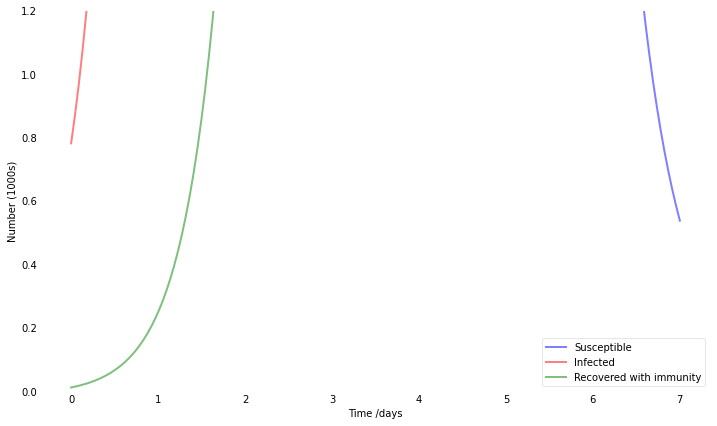

In [18]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w', figsize=(12,7))
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()